## Attention linking PoC: Part II

This is an overview of the research of utilizing attention in aim for more accurate and transparent Information Retrieval.

### Hyphotesis:

Transformers' attention reflects the internal relations of entities in the text and hence does reflect the importance of the pieces of text.

### Experiment Methodology:

As shown in `attention_linking.ipynb`, the attention heads are variously good at dinstingiushing the keyphrases of the texts.

Now, given that we know how well the attention itself does, we'll methodically select a subset of them to predict the importance of the tokens.

- We'll select a certain number of heads and will do token classification based on their attentions as features.

- We'll order the heads from best- to worst-distinguishing, according to the criteria: **cross-entropy to the target**. We'll be continuously increasing a number of heads from best to worst and will observe, how they perform on aforementioned token classification.

### Evaluation

We'll measure an accuracy of token classification, based on selected heads' attention, on validation set. We'll plot this accuracy and seek for optimum.

### Outputs

We'll see, how well best-performing heads can do. Eventually, we will compare this result with token classification of the whole Transformers' models.

The best-performing methodology will be used for kephrase selection and respective weighting of the pieces of text in IRSystem.

In [1]:
from common import *
import random

In [2]:
ktexts = get_keyphrased_texts()

In [3]:
model_id = "bert"
firstn = 100

tokenizer, model = get_tokenizer_model(model_id)
# links_l = []
links_l_bert = []

# TODO: missing 'misleading' in doc #2
for kw_key, ktext in tqdm(tuple(ktexts.items())[:firstn], desc=model_id):
    wpieces, attention = get_attentions(ktext['text'], model, tokenizer)
    kwds_postproc = [kw for kw in ktext['keywords'] if len(kw)>2]
    kwds_postproc += [" "+kw for kw in kwds_postproc]
    keywd_mask = get_keyphrases_mask(wpieces, [kw for kw in ktext['keywords'] if len(kw)>2], tokenizer).bool()
#     print([tokenizer.convert_ids_to_tokens(tokenizer.encode_plus(kw)["input_ids"]) for kw in kwds_postproc])
#     assert len(keywd_mask) == len(wpieces)
# #     print(list(zip(keywd_mask, [wp.item() for wp in wpieces])))
#     print([wp.item() for wp in wpieces])

    records = []
    negative_records = []
    # consider all heads 
    
    for wp_i, wpiece in enumerate(wpieces[keywd_mask]):
        sample = {"wordpiece": wpiece, "is_kw": True, "kname": kw_key, "model": model_id}
        for pool, is_max_pool in zip(["max", "mean"], [True, False]):
            for l_i, h_i in [(l, h) for l in range(12) for h in range(12)]:
                head_weights = attention[l_i][0][h_i][keywd_mask][wp_i]
                sample["l_%s_h_%s_%s" % (l_i, h_i, pool)] = head_weights.max().item() if is_max_pool \
                                                                                             else head_weights.mean().item()
            links_l_bert.append(sample)
    # add the same number of negative samples, but for the same layers and heads
    for wp_i, wpiece in enumerate(wpieces[keywd_mask]):
        sample = {"wordpiece": wpiece, "is_kw": False, "kname": kw_key, "model": model_id}
        for pool, is_max_pool in zip(["max", "mean"], [True, False]):
            for l_i, h_i in [(l, h) for l in range(12) for h in range(12)]:
                head_weights = attention[l_i][0][h_i][keywd_mask][wp_i]
                sample["l_%s_h_%s_%s" % (l_i, h_i, pool)] = head_weights.max().item() if is_max_pool \
                                                                                             else head_weights.mean().item()
            links_l_bert.append(sample)
            
links_df = pd.DataFrame(links_l_bert)
#     return features_all

bert: 100%|██████████| 100/100 [05:53<00:00,  3.53s/it]


In [ ]:
for pool in [True, False]:
    for l_i, h_i in (l_i, h_i for l_i in range(12) for h_i in range(12)):
        links_df.loc["l_%s_h_%s_%s" % (l_i, h_i, pool) "layer"] = 

<ipython-input-25-c51a3c3dad00>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax = links_df[k][links_df.kname.isin(subsampled_knames)][links_df.is_kw].sort_values(by="l_11_h_6_max").reset_index(drop=True).plot(alpha=0.2, legend=False, grid=True, figsize=(15, 5), title="Attention values for keywords, for each of 144 heads, %s pooling strategy" % pooling)


Text(0, 0.5, 'Wordpiece attention value')

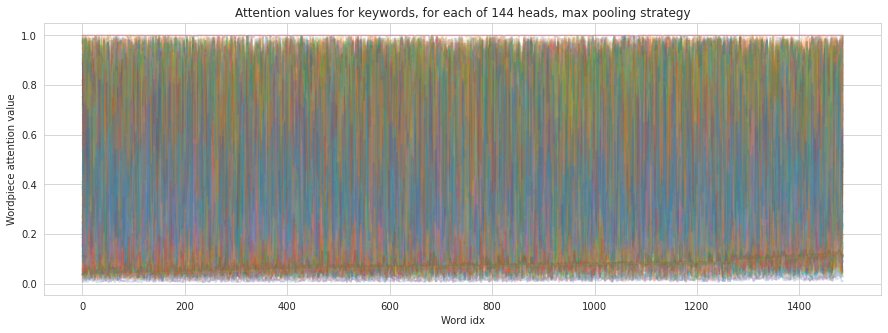

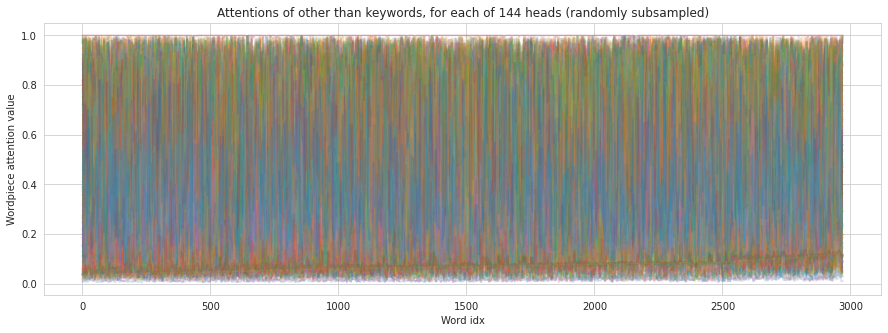

In [25]:
pooling = "max"

k = ["l_%s_h_%s_%s" % (l_i, h_i, pooling) for l_i in range(12) for h_i in range(12)]

subsampled_knames = list(links_df.kname.sample(10).unique())

ax = links_df[k][links_df.kname.isin(subsampled_knames)][links_df.is_kw].sort_values(by="l_11_h_6_max").reset_index(drop=True).plot(alpha=0.2, legend=False, grid=True, figsize=(15, 5), title="Attention values for keywords, for each of 144 heads, %s pooling strategy" % pooling)
ax.set_xlabel("Word idx")
ax.set_ylabel("Wordpiece attention value")

ax2 = links_df[k][links_df.kname.isin(subsampled_knames)].sort_values(by="l_11_h_6_max").reset_index(drop=True).plot(alpha=0.2, legend=False, grid=True, figsize=(15, 5), title="Attentions of other than keywords, for each of 144 heads (randomly subsampled)")
ax2.set_xlabel("Word idx")
ax2.set_ylabel("Wordpiece attention value")

Text(0, 0.5, 'Wordpiece attention value')

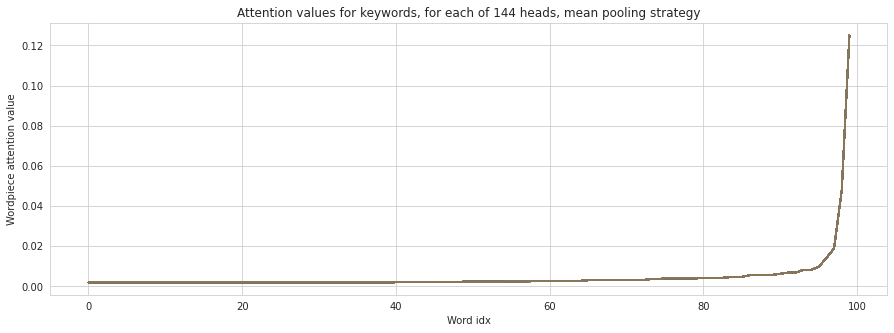

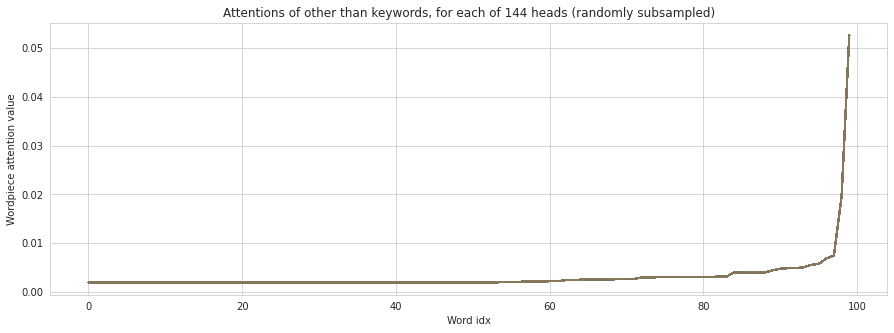

In [26]:
pooling = "mean"

k = ["l_%s_h_%s_%s" % (l_i, h_i, pooling) for l_i in range(12) for h_i in range(12)]

ax = links_df[k][links_df.is_kw].sample(100).sort_values(by="l_11_h_6_mean").reset_index(drop=True).plot(alpha=0.2, legend=False, grid=True, figsize=(15, 5), title="Attention values for keywords, for each of 144 heads, %s pooling strategy" % pooling)
ax.set_xlabel("Word idx")
ax.set_ylabel("Wordpiece attention value")

ax2 = links_df[k][~links_df.is_kw].sample(100).sort_values(by="l_11_h_6_mean").reset_index(drop=True).plot(alpha=0.2, legend=False, grid=True, figsize=(15, 5), title="Attentions of other than keywords, for each of 144 heads (randomly subsampled)")
ax2.set_xlabel("Word idx")
ax2.set_ylabel("Wordpiece attention value")

/home/xstefan3/miniconda3/envs/cc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/home/xstefan3/miniconda3/envs/cc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/home/xstefan3/miniconda3/envs/cc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/home/xstefan3/miniconda3/envs/cc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/home/xstefan3/miniconda3/envs/cc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be u

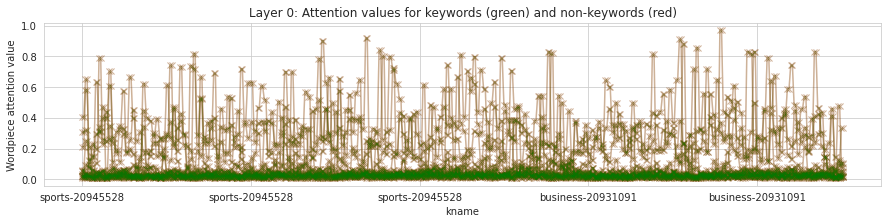

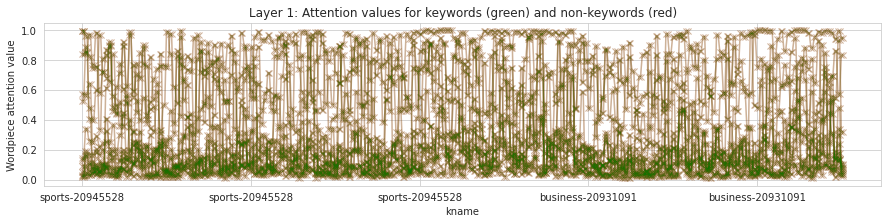

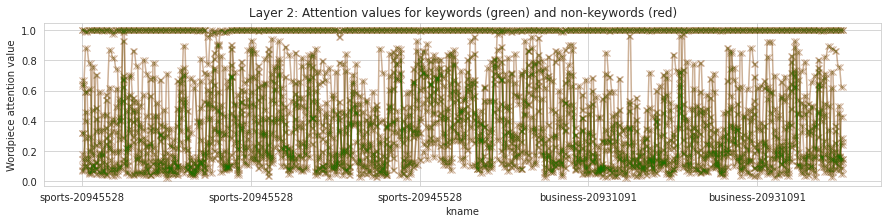

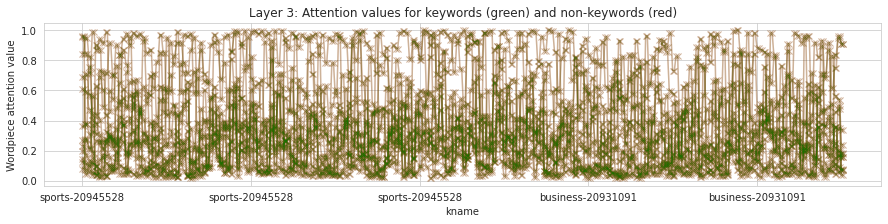

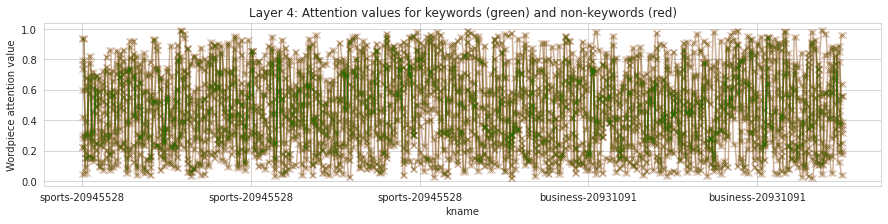

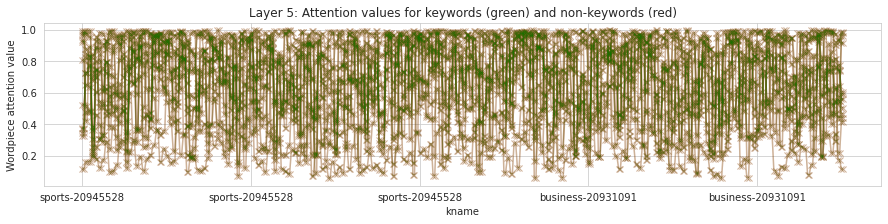

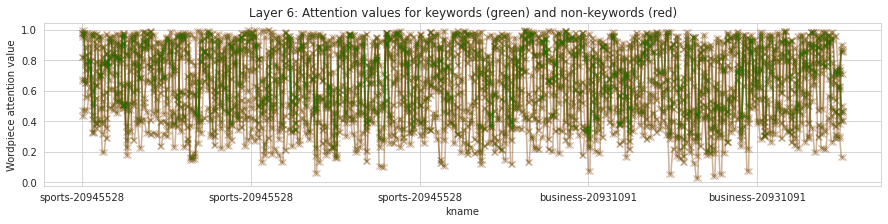

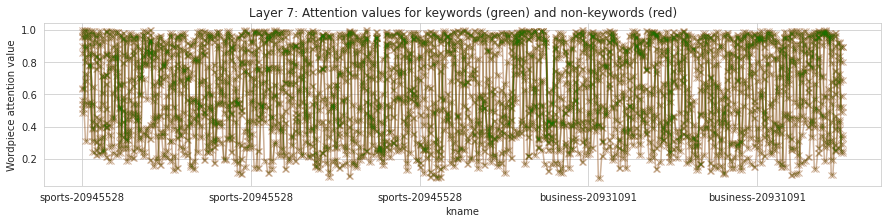

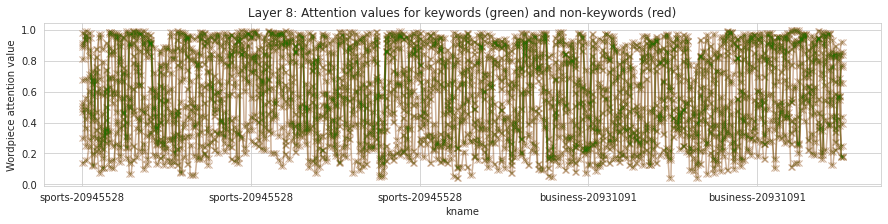

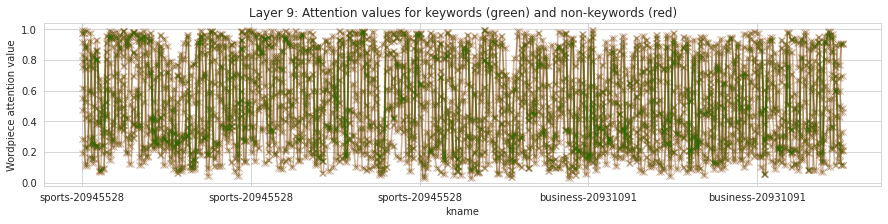

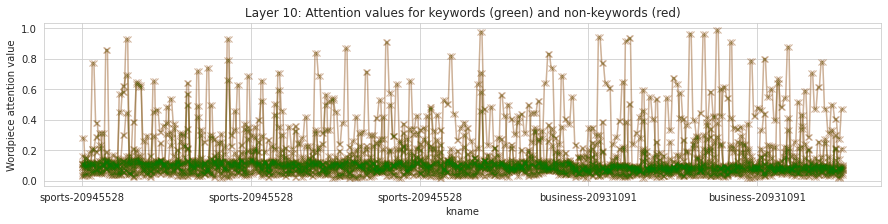

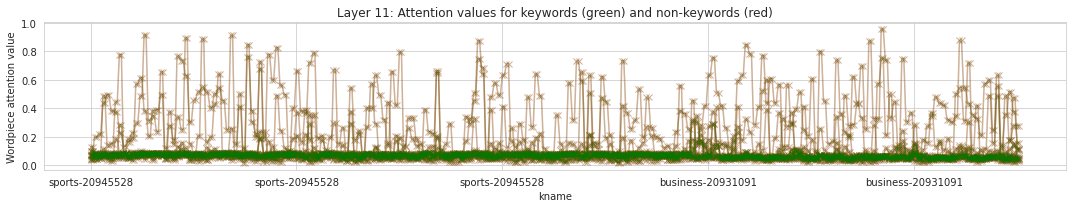

In [24]:
# per-layer(s) attention comparison: positive and negative samples
import seaborn as sns
import matplotlib.pyplot as plt
sampled_kwnames = links_df.kname.sample(2).unique()
sample_df = links_df[links_df.kname.isin(sampled_kwnames)].set_index("kname", drop=True)

for l_i in range(12):
    k = ["l_%s_h_%s_%s" % (l_i, h_i, pool) for h_i in range(12) for pool in ["max"]]
    
    ax = sample_df[k][~sample_df.is_kw]\
    .plot(marker="x", alpha=0.25, legend=False, grid=True, figsize=(15, 3), color="red")

    ax = sample_df[k][sample_df.is_kw]\
    .plot(ax=ax, marker="x", alpha=0.20, legend=False, grid=True, color="green", title="Layer %s: Attention values for keywords (green) and non-keywords (red)" % l_i)
    ax.set_ylabel("Wordpiece attention value")

plt.tight_layout()

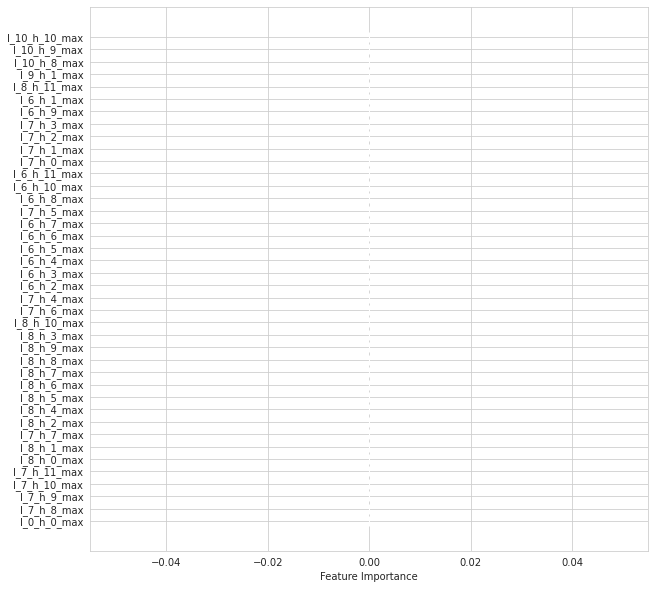

In [16]:
# MAX strategy
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt

X_cols = ["l_%s_h_%s_%s" % (l, h, p) for l in range(12) for h in range(12) for p in ["max"]]
topn_features = 40

clf = LogisticRegression(random_state = 0)
clf.fit(links_df[X_cols], links_df["is_kw"])

feature_importance = abs(clf.coef_[0])
# feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = (np.arange(sorted_idx.shape[0]) + .5)[:topn_features]

featfig = plt.figure(figsize=(10, 10))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx][:topn_features], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X_cols)[sorted_idx][:topn_features])
featax.set_xlabel('Feature Importance')
plt.show()
# all features importance is zero

/home/xstefan3/miniconda3/envs/cc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:>

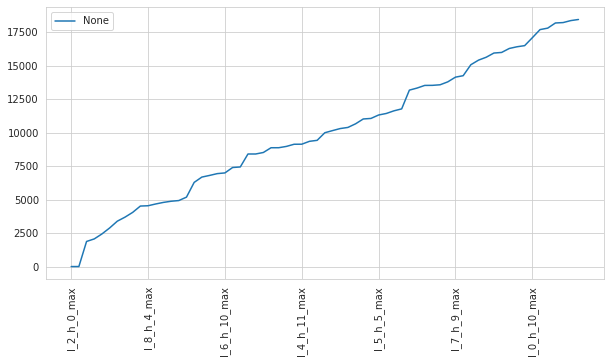

In [116]:
import math

def cross_entropy(p, q):
    return -sum([p[i]*math.log2(q[i]) for i in range(len(p))])

entropies = links_df[X_cols].apply(lambda col: cross_entropy(links_df.is_kw.values, col), axis=0)
entropies.sort_values().plot(figsize=(10, 5), rot=90, legend="Features' entropies")

/home/xstefan3/miniconda3/envs/cc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:>

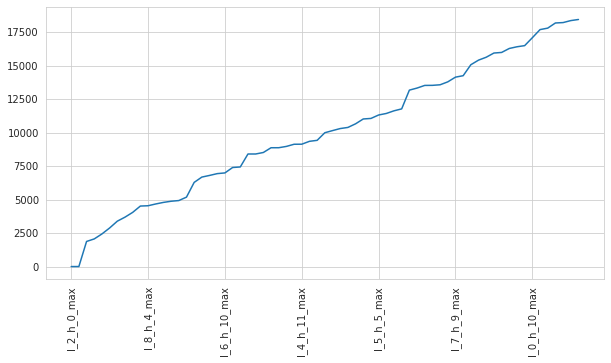

In [118]:
entropies.sort_values().plot(figsize=(10, 5), rot=90)

In [39]:
entropies.sort_values().head(10)

l_2_h_0_max      20.466552
l_2_h_9_max      23.297212
l_7_h_3_max    1894.318051
l_7_h_7_max    2083.535294
l_7_h_6_max    2455.226861
l_5_h_7_max    2899.598139
l_5_h_1_max    3407.217381
l_8_h_5_max    3707.706600
l_8_h_0_max    4063.854563
l_9_h_4_max    4535.810778
dtype: float64

In [130]:
from sklearn.utils import shuffle
shuffle(links_df[["l_2_h_0_max", "l_2_h_9_max", "is_kw"]]).reset_index(drop=True).head(30)

l_2_h_0_max  l_2_h_9_max  is_kw
0      0.999976     0.999969   True
1      0.999893     0.999896  False
2      0.999979     0.999961   True
3      0.999999     1.000000   True
4      0.999935     0.999933  False
5      0.999995     0.999985   True
6      0.996371     0.996730  False
7      0.999999     1.000000  False
8      0.999998     0.999998  False
9      0.999994     0.999984   True
10     0.999989     0.999989  False
11     0.999697     0.999451  False
12     0.999821     0.999885  False
13     0.999635     0.995963  False
14     0.999961     0.999911  False
15     0.999635     0.999663   True
16     0.999730     0.999932  False
17     0.999981     0.999976  False
18     0.999997     0.999997   True
19     0.999960     0.999937  False
20     0.999943     0.999880  False
21     0.992303     0.988286  False
22     0.999999     0.999999   True
23     0.999870     0.999889  False
24     0.999998     0.999999   True
25     0.999701     0.999635  False
26     0.998758     0.998859   True
27     0.999997     0.999993  False
28     0.999905     0.999811  False
29     0.999084     0.992962   True

In [66]:
# from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, f1_score
X_cols = ["l_%s_h_%s_%s" % (l, h, p) for l in range(12) for h in range(12) for p in ["max"]]

# clf = RandomForestClassifier(n_estimators=500)
clf = LogisticRegression(random_state = 0, max_iter=2000)
clf.fit(links_df[X_cols].iloc[:20000], links_df["is_kw"].iloc[:20000])
preds = clf.predict(links_df[X_cols].iloc[20000:])
trues = links_df["is_kw"].iloc[20000:]
print(f1_score(trues, preds))

0.5490096495683089


In [ ]:
fscores_trees = {}
for top_i in range(2, int(len(entropies)/2), 5):
    X_cols = list(entropies.sort_values().head(top_i).index.values)
#     clf = LogisticRegression(random_state = 0, max_iter=2000)
    clf = RandomForestClassifier(max_depth=4)

    clf.fit(links_df[X_cols].iloc[:20000], links_df["is_kw"].iloc[:20000])
    preds = clf.predict(links_df[X_cols].iloc[20000:])
    trues = links_df["is_kw"].iloc[20000:]
    fscores_trees[top_i] = f1_score(trues, preds)
    print(f1_score(trues, preds))

<AxesSubplot:title={'center':'F1-scores'}>

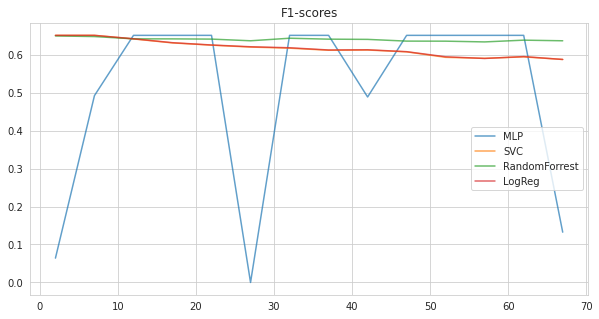

In [109]:
pd.DataFrame({"MLP": fscores_mlp, "SVC": fscores_svc, "RandomForrest": fscores_trees, "LogReg": fscores_logreg}).plot(alpha=0.7, figsize=(10, 5), title="F1-scores")

<AxesSubplot:>

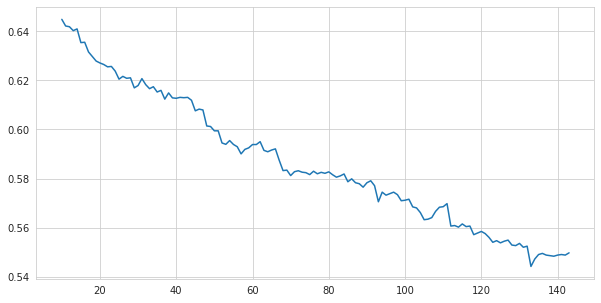

In [69]:
# Logistic Regression
pd.Series(fscores).plot(figsize=(10, 5))

In [120]:
# MEAN strategy
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt

X_cols = ["l_%s_h_%s_%s" % (l, h, p) for l in range(12) for h in range(12) for p in ["mean"]] 
topn_features = 50

clf = LogisticRegression(random_state = 0)
clf.fit(links_df[X_cols], links_df["is_kw"])

feature_importance = abs(clf.coef_[0])
# feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = (np.arange(sorted_idx.shape[0]) + .5)[:topn_features]

/home/xstefan3/miniconda3/envs/cc/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:>

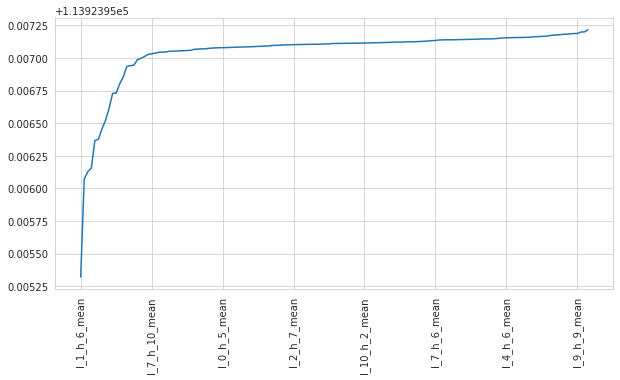

In [121]:
entropies = links_df[X_cols].apply(lambda col: cross_entropy(links_df.is_kw.values, col), axis=0)
entropies.sort_values().plot(figsize=(10, 5), rot=90)

In [129]:
# all seem too high, but work similarily well for prediction(?)
entropies.sort_values().head(10)

l_1_h_6_mean     113923.955323
l_3_h_5_mean     113923.956073
l_1_h_4_mean     113923.956129
l_3_h_9_mean     113923.956156
l_1_h_1_mean     113923.956367
l_5_h_9_mean     113923.956377
l_7_h_4_mean     113923.956457
l_6_h_11_mean    113923.956521
l_3_h_11_mean    113923.956612
l_6_h_9_mean     113923.956728
dtype: float64

In [28]:
# all features' prediction
from sklearn.metrics import classification_report
clf = LogisticRegression(random_state = 0, max_iter=2000)
clf.fit(links_df[X_cols].iloc[:20000], links_df["is_kw"].iloc[:20000])
preds = clf.predict(links_df[X_cols].iloc[20000:])
trues = links_df["is_kw"].iloc[20000:]
print(classification_report(trues, preds))

              precision    recall  f1-score   support

       False       0.50      0.32      0.39      3552
        True       0.47      0.65      0.55      3312

    accuracy                           0.48      6864
   macro avg       0.49      0.49      0.47      6864
weighted avg       0.49      0.48      0.47      6864



In [ ]:
fscores = {"LogReg": {}, "trees": {}, "MLP": {}, "SVC": {}}

for cfr_name, cfr in zip(fscores.keys(), [LogisticRegression(), RandomForestClassifier(max_depth=4, n_jobs=-1), 
                                         MLPClassifier((50, 50)), LinearSVC()]):
    print(cfr_name)
    for top_i in range(2, int(len(entropies)/2), 2):
        X_cols = list(entropies.sort_values().head(top_i).index.values)
    #     clf = LogisticRegression(random_state = 0, max_iter=2000)

        cfr.fit(links_df[X_cols].iloc[:20000], links_df["is_kw"].iloc[:20000])
        preds = cfr.predict(links_df[X_cols].iloc[20000:])
        trues = links_df["is_kw"].iloc[20000:]
        fscores[cfr_name][top_i] = f1_score(trues, preds)
        print(f1_score(trues, preds))

<AxesSubplot:title={'center':'F1-scores'}>

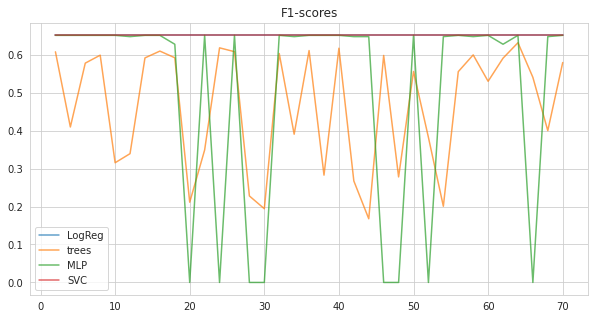

In [127]:
pd.DataFrame(fscores).plot(alpha=0.7, figsize=(10, 5), title="F1-scores")

### Conclusions

Despite that the relative attention ratios of keywords-to-no-keywords are distinct, the features based on solemn attention seem to have no expressivity for independently classifying the keywords. 

Interestingly, using the MAX pooling strategy, we identify the two heads with significantly lower entropy (around 20): "l_2_h_0_max" and "l_2_h_9_max". These are however still not good enough in standalone.